# Параллельные вычисления (1)

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Параллельные вычисления"
* https://docs.python.org/3/library/multiprocessing.html
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Process
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Queue
* https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
* https://numpy.org/doc/stable/reference/generated/numpy.array_split.html

## Задачи для совместного разбора

In [1]:
import py7zr
import os
import gdown
import time
import multiprocessing
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
# gdown.download(id='14hv77ddkmpcHeJgZ_lD5hqYtWHvi2zJV', output= 'file.7z', quiet=False)

# archive_path = '/content/file.7z'
extract_path = '/content'
# os.makedirs(extract_path, exist_ok=True)
# with py7zr.SevenZipFile(archive_path, mode='r') as z:
#     z.extractall(path=extract_path)
# print(f"Archive extracted to {extract_path}")

1. Посчитайте, сколько раз встречается буква "a" в файлах ["xaa", "xab", "xac", "xad"], используя пул процессов.

In [4]:
files = [extract_path+f"/data/{name}.txt" for name in ["xaa", "xab", "xac", "xad"]]


def count_letter_a(filename):
    """Функция для подсчёта количества букв 'a' в одном файле."""
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            content = f.read()
        return content.count('a')
    except FileNotFoundError:
        print(f"Файл не найден: {filename}")
        return 0
    except Exception as e:
        print(f"Ошибка при чтении файла {filename}: {e}")
        return 0


with multiprocessing.Pool(4) as pool:
    results = pool.map(count_letter_a, files)

total_count = sum(results)

print(f"Общее количество букв 'a' во всех файлах: {total_count}")

Общее количество букв 'a' во всех файлах: 8998272


2. Посчитайте, сколько раз встречается буква "a" в файлах ["xaa", "xab", "xac", "xad"], используя процессы и очереди.

In [5]:
def count_letter_a(filename):
    """Подсчёт букв 'a' в одном файле с обработкой ошибок."""
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            return f.read().count('a')
    except Exception as e:
        print(f"Ошибка в {filename}: {e}")
        return 0


def worker(filename, queue):
    """Рабочая функция для процесса: считает буквы и отправляет результат в очередь."""
    count = count_letter_a(filename)
    queue.put(count)



result_queue = multiprocessing.Queue()
processes = []

for file in files:
    p = multiprocessing.Process(target=worker, args=(file, result_queue))
    processes.append(p)
    p.start()

# Ждём завершения всех процессов
for p in processes:
    p.join()

# Собираем результаты из очереди
total_count = 0
for _ in range(len(files)):
    total_count += result_queue.get()

print(f"Общее количество букв 'a': {total_count}")

Общее количество букв 'a': 8998272


## Лабораторная работа 5

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy` и `pandas`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy` или структур `pandas` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

<p class="task" id="1"></p>

1\. В каждой строке файла `tag_nsteps.csv` хранится информация о тэге рецепта и количестве шагов в этом рецепте в следующем виде:

```
tags,n_steps
hungarian,2
european,6
occasion,4
pumpkin,4
................
```

Всего в исходном файле хранится чуть меньше, чем 71 млн, строк. Разбейте файл `tag_nsteps.csv` на несколько (например, 8) примерно одинаковых по объему файлов c названиями `tag_nsteps_*.csv`, где вместо символа `*` указан номер очередного файла. Каждый файл имеет структуру, аналогичную оригинальному файлу (включая заголовок).

При создании файлов выводите на экран сообщения следующего вида:
`file: <название файла> #rows: <кол-во строк в этом файле>`

__Важно__: здесь и далее вы не можете загружать в память весь исходный файл сразу.

In [6]:
def split_large_csv(input_filename):
    num_parts = 8

    # Открываем исходный файл для чтения
    with open(input_filename, 'r') as infile:
        header = infile.readline()
          # Читаем заголовок

        # Создаем 8 выходных файлов с заголовком
        output_files = []
        counts = [0] * num_parts  # Счетчики строк для каждого файла

        for i in range(num_parts):
            filename = f"tag_nsteps_{i}.csv"
            f = open(filename, 'w')
            f.write(header)  # Записываем заголовок
            output_files.append(f)

        # Распределяем данные по файлам
        current_file = 0
        for line in infile:
            output_files[current_file].write(line)
            counts[current_file] += 1
            current_file = (current_file + 1) % num_parts

        # Закрываем все выходные файлы
        for f in output_files:
            f.close()

    # Выводим отчет
    for i in range(num_parts):
        filename = f"tag_nsteps_{i}.csv"
        total_rows = 1 + counts[i]  # 1 строка заголовка + данные
        print(f"file: {filename} #rows: {total_rows}")

split_large_csv("/content/data/tag_nsteps.csv")

file: tag_nsteps_0.csv #rows: 8836950
file: tag_nsteps_1.csv #rows: 8836949
file: tag_nsteps_2.csv #rows: 8836949
file: tag_nsteps_3.csv #rows: 8836949
file: tag_nsteps_4.csv #rows: 8836949
file: tag_nsteps_5.csv #rows: 8836949
file: tag_nsteps_6.csv #rows: 8836949
file: tag_nsteps_7.csv #rows: 8836949


<p class="task" id="2"></p>

2\. Напишите функцию, которая принимает на вход название файла, созданного в результате решения задачи 1, считает для каждого тэга сумму по столбцу `n_steps` и количество строк c этим тэгом, и возвращает результат в виде словаря. Ожидаемый вид итогового словаря:

```
{
    '1-day-or-more': {'sum': 56616, 'count': 12752},
    '15-minutes-or-less': {'sum': 195413, 'count': 38898},
    '3-steps-or-less': {'sum': 187938, 'count': 39711},
    ....
}
```

Примените данную функцию к каждому файлу, полученному в задании 1, и соберите результат в виде списка словарей. Не используйте параллельных вычислений.

Выведите на экран значение по ключу "30-minutes-or-less" для каждого из словарей.

In [13]:
def get_tag_sum_count_from_file(file: str) -> dict:
    """Обрабатывает файл, возвращая словарь с суммой n_steps и количеством строк для каждого тега."""
    tag_stats = {}
    with open(file, 'r') as f:
        next(f)  # Пропускаем заголовок
        for line in f:
            tag, n_steps_str = line.strip().split(',')
            n_steps = int(n_steps_str)

            if tag in tag_stats:
                tag_stats[tag]['sum'] += n_steps
                tag_stats[tag]['count'] += 1
            else:
                tag_stats[tag] = {'sum': n_steps, 'count': 1}
    return tag_stats

# Применяем функцию ко всем файлам из задачи 1
file_names = [f"tag_nsteps_{i}.csv" for i in range(8)]
results = [get_tag_sum_count_from_file(fname) for fname in file_names]

# Выводим значения для тега "30-minutes-or-less" из каждого словаря
for i, res in enumerate(results):
    value = res.get("30-minutes-or-less", None)
    print(f"File {i}: {value}")

File 0: {'sum': 346395, 'count': 45499}
File 1: {'sum': 345965, 'count': 45416}
File 2: {'sum': 350627, 'count': 45912}
File 3: {'sum': 353133, 'count': 46392}
File 4: {'sum': 345153, 'count': 45534}
File 5: {'sum': 346416, 'count': 45662}
File 6: {'sum': 350770, 'count': 45981}
File 7: {'sum': 344746, 'count': 45386}


<p class="task" id="3"></p>

3\. Напишите функцию, которая объединяет результаты обработки отдельных файлов. Данная функция принимает на вход список словарей, каждый из которых является результатом вызова функции `get_tag_sum_count_from_file` для конкретного файла, и агрегирует эти словари. Не используйте параллельных вычислений.

Процедура агрегации словарей имеет следующий вид:
$$d_{agg}[k] = \{sum: \sum_{i=1}^{n}d_{i}[k][sum], count: \sum_{i=1}^{n}d_{i}[k][count]\}$$
где $d_1, d_2, ..., d_n$- результат вызова функции `get_tag_sum_count_from_file` для конкретных файлов.

Примените данную функцию к результату выполнения задания 2. Выведите на экран результат для тэга "30-minutes-or-less".

In [14]:
from collections import defaultdict

def agg_results(tag_sum_count_list: list) -> dict:
    aggregated_results = defaultdict(lambda: {'sum': 0, 'count': 0})
    for individual_file_result in tag_sum_count_list:
        for tag, stats in individual_file_result.items():
            aggregated_results[tag]['sum'] += stats['sum']
            aggregated_results[tag]['count'] += stats['count']
    return dict(aggregated_results)

results_agg = agg_results(results)
print(results_agg['30-minutes-or-less'])

{'sum': 2783205, 'count': 365782}


<p class="task" id="4"></p>

4\. Напишите функцию, которая считает среднее значение количества шагов для каждого тэга в словаре. Используйте решения задач 1-3, чтобы получить среднее значение количества шагов каждого тэга для всего датасета, имея результаты обработки частей датасета и результат их агрегации. Выведите на экран результат для тэга "30-minutes-or-less".

Определите, за какое время задача решается для всего датасета. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла, можно пренебречь.

In [15]:
def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    # tag_sum_count - результат вызова agg_results
    res_dict = dict()
    for k,v in tag_sum_count.items():
      res_dict[k] = tag_sum_count[k]['sum']/tag_sum_count[k]['count']

    return res_dict

get_tag_mean_n_steps(results_agg)['30-minutes-or-less']

7.608917333275011

<p class="task" id="5"></p>

5\. Повторите решение задачи 4, распараллелив вызовы функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Pool`. Для обработки каждого файла создайте свой собственный процесс. Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [16]:
start_time = time.perf_counter()

# multiprocessing.Pool
with multiprocessing.Pool() as pool:
    parallel_results = pool.map(get_tag_sum_count_from_file, file_names)

# 3
agg_parallel_results = agg_results(parallel_results)

# 4
mean_n_steps_parallel = get_tag_mean_n_steps(agg_parallel_results)

end_time = time.perf_counter()

# Prints '30-minutes-or-less'
print(f"Agg res: {agg_parallel_results['30-minutes-or-less']}")
print(f"Mean: {mean_n_steps_parallel['30-minutes-or-less']}")

print(f"Total execution time: {end_time - start_time:.4f} seconds")

Agg res: {'sum': 2783205, 'count': 365782}
Mean: 7.608917333275011
Total execution time: 38.3601 seconds


<p class="task" id="6"></p>

6\. Повторите решение задачи 4, распараллелив вычисления функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Process`. Для обработки каждого файла создайте свой собственный процесс. Для обмена данными между процессами используйте `multiprocessing.Queue`.

Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [20]:
start_time = time.perf_counter()

queue = multiprocessing.Queue()

def worker_queue(filename, q):
    result = {}
    result = get_tag_sum_count_from_file(filename)
    q.put(result)

processes = []
for fname in file_names:
    p = multiprocessing.Process(target=worker_queue, args=(fname, queue))
    processes.append(p)
    p.start()

queue_results = []
for _ in file_names:
    queue_results.append(queue.get())

for p in processes:
    p.join()

# 3
agg_queue_results = agg_results(queue_results)

# 4
mean_n_steps_queue = get_tag_mean_n_steps(agg_queue_results)

end_time = time.perf_counter()

print(f"Agg res: {agg_queue_results['30-minutes-or-less']}")
print(f"Mean: {mean_n_steps_queue['30-minutes-or-less']}")

print(f"Total execution time with multiprocessing.Process and Queue: {end_time - start_time:.4f} seconds")

Agg res: {'sum': 2783205, 'count': 365782}
Mean: 7.608917333275011
Total execution time with multiprocessing.Process and Queue: 47.1444 seconds


<p class="task" id="7"></p>

7\. Исследуйте, как влияет количество запущенных одновременно процессов на скорость решения задачи. Узнайте количество ядер вашего процессора $K$ (воспользуйтесь функцией `multiprocessing.cpu_count`). Повторите решение задачи 1, разбив исходный файл на $\frac{K}{2}$, $K$ и $2K$ фрагментов. Для каждого из разбиений повторите решение задачи 5. Визуализируйте зависимость времени выполнения кода от количества файлов в разбиении. Сделайте вывод в виде текстового комментария.

Number of CPU cores (K): 2

Processing with 1 fragments...
Execution time for 1 fragments: 45.8200 seconds

Processing with 2 fragments...
Execution time for 2 fragments: 39.0965 seconds

Processing with 4 fragments...
Execution time for 4 fragments: 43.5021 seconds


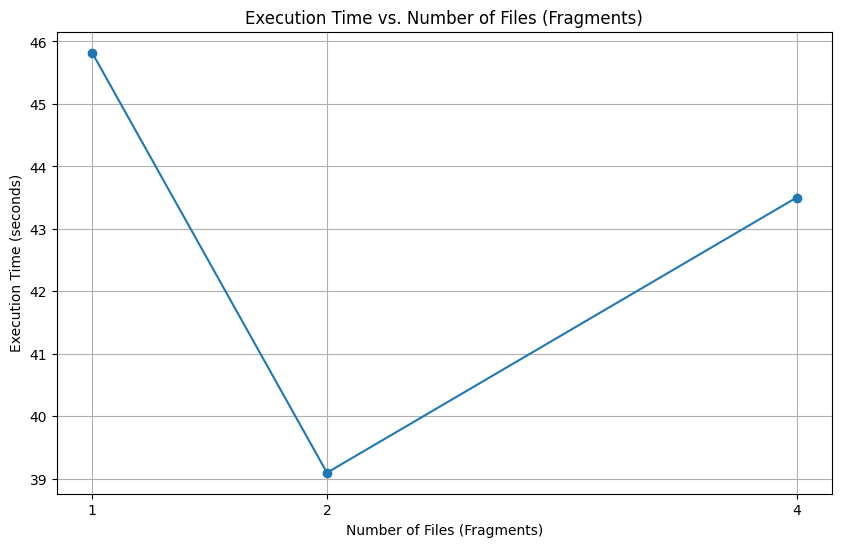

Согласно результатам эксперимента, задача выполнялась быстрее всего при разделении файла на 2 фрагмента (что в данном случае соответствует K = 2 ядрам). Это говорит о том, что использование количества процессов, равного количеству ядер процессора, обеспечивает хорошую производительность, вероятно, благодаря эффективному использованию доступных аппаратных ресурсов без чрезмерных накладных расходов на управление процессами при использовании меньшего количества процессов, чем ядер, или на переключение контекста и коммуникационные издержки при использовании значительно большего количества процессов, чем ядер.


In [23]:
def split_csv_into_n_parts(input_filename, num_parts, output_prefix):
    output_filenames = []
    with open(input_filename, 'r') as infile:
        header = infile.readline()

        output_files = []
        for i in range(num_parts):
            filename = f"{output_prefix}_{i}.csv"
            f = open(filename, 'w')
            f.write(header)
            output_files.append(f)
            output_filenames.append(filename)

        current_file_idx = 0
        for line in infile:
            output_files[current_file_idx].write(line)
            current_file_idx = (current_file_idx + 1) % num_parts

        for f in output_files:
            f.close()
    return output_filenames

K = multiprocessing.cpu_count()
print(f"Number of CPU cores (K): {K}")

# Ensure K_half is at least 1
K_half = max(1, K // 2)

num_fragments_configs = [K_half, K, K * 2]

execution_times = []
fragment_counts = []

for num_parts in num_fragments_configs:
    print(f"\nProcessing with {num_parts} fragments...")
    output_prefix = f"tag_nsteps_dynamic_{num_parts}"
    dynamic_filenames = split_csv_into_n_parts(
        "/content/data/tag_nsteps.csv",
        num_parts,
        output_prefix
    )

    start_time = time.perf_counter()

    with multiprocessing.Pool(num_parts) as pool:
        parallel_results = pool.map(get_tag_sum_count_from_file, dynamic_filenames)

    agg_parallel_results = agg_results(parallel_results)

    mean_n_steps_parallel = get_tag_mean_n_steps(agg_parallel_results)

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time

    execution_times.append(elapsed_time)
    fragment_counts.append(num_parts)
    print(f"Execution time for {num_parts} fragments: {elapsed_time:.4f} seconds")

    # Optional: Clean up generated files
    for fname in dynamic_filenames:
        os.remove(fname)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(fragment_counts, execution_times, marker='o')
plt.title('Execution Time vs. Number of Files (Fragments)')
plt.xlabel('Number of Files (Fragments)')
plt.ylabel('Execution Time (seconds)')
plt.xticks(fragment_counts)
plt.grid(True)
plt.show()

# Conclusion
min_time_idx = execution_times.index(min(execution_times))
optimal_fragments = fragment_counts[min_time_idx]
print(f"Согласно результатам эксперимента, задача выполнялась быстрее всего при разделении файла на {optimal_fragments} фрагмента (что в данном случае соответствует K = {K} ядрам). Это говорит о том, что использование количества процессов, равного количеству ядер процессора, обеспечивает хорошую производительность, вероятно, благодаря эффективному использованию доступных аппаратных ресурсов без чрезмерных накладных расходов на управление процессами при использовании меньшего количества процессов, чем ядер, или на переключение контекста и коммуникационные издержки при использовании значительно большего количества процессов, чем ядер.")